# Election Simulation Analysis

This notebook analyzes the results of the election simulation.


In [37]:
files = [
    "../logs/2025-07-21_10-56-37/checkpoint.json",
    "../logs/2025-07-21_13-46-49/checkpoint.json",
    "../logs/2025-07-21_16-26-25/checkpoint.json",
]

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = []

for file in files:
    with open(file) as f:
        data1 = json.load(f)
        data.append(data1)

sim_data = data[0]  # data used to analayze

In [39]:
def get_voter_agents(data):
    people = {}
    for person in data["people_agents"]:
        people[person["name"]] = person

    return people


def get_voter_names(data):
    people = get_voter_agents(data)
    return [person["name"] for person in people.values()]


def get_candidate_agents(data):
    candidates = {}
    for candidate in data["candidate_agents"]:
        candidates[candidate["name"]] = candidate

    return candidates


def get_candidate_names(data, include_abstain=False):
    candidates = get_candidate_agents(data)
    candidate_names = [candidate["name"] for candidate in candidates.values()]
    if include_abstain:
        return candidate_names + ["ABSTAIN"]
    else:
        return candidate_names


def get_all_agents(data):
    people = get_voter_agents(data)
    candidates = get_candidate_agents(data)

    agents = {**people, **candidates}

    return agents


def get_vote_history(data):
    return data.get("who_voted_for_who_history", [])

In [40]:
CATEGORIES = {
    "gender": ["male", "female", "non-binary"],
    "race": [
        "White",
        "Black or African American",
        "Asian",
        "Hispanic or Latino",
        "Native American",
        "Pacific Islander",
    ],
    "family_status": [
        "Single",
        "Married",
        "Divorced",
        "Widowed",
        "Cohabitating",
    ],
    "religious_stance": [
        "Single",
        "Married",
        "Divorced",
        "Widowed",
        "Cohabitating",
    ],
    "education_level": [
        "High School",
        "Trade School",
        "Community College",
        "Bachelor's Degree",
        "Master's Degree",
        "Doctorate",
    ],
    "community_type": [
        "Urban",
        "Suburban",
        "Rural",
        "Small Town",
        "Metropolitan Area",
        "Tech Hub",
    ],
    "employment_sector": [
        "Not Employed",
        "Manufacturing",
        "Service Industry",
        "Technology",
        "Healthcare",
        "Education",
        "Finance",
        "Government",
        "Non-Profit",
        "Business Owner",
    ],
}


def calculate_similarity(voter_profile, candidate_profile):
    """Calculate cosine similarity between a voter and candidate based on their background profiles."""
    import numpy as np
    import math

    voter_bg = voter_profile.get("background", {})
    candidate_bg = candidate_profile.get("background", {})

    if not voter_bg or not candidate_bg:
        return 0

    voter_vector = []
    candidate_vector = []

    political_attrs = [
        "economic_policy",
        "social_authority",
        "governmental_power",
        "foreign_policy",
        "environmental_approach",
        "national_identity",
        "openness",
        "conscientiousness",
        "extraversion",
        "agreeableness",
        "emotional_stability",
    ]
    for attr in political_attrs:
        voter_score = voter_bg.get(attr, 0)  # Default to neutral 0 if missing
        cand_score = candidate_bg.get(attr, 0)
        voter_vector.append(voter_score / 100.0)
        candidate_vector.append(cand_score / 100.0)

    # cosine similarity
    voter_vector = np.array(voter_vector)
    candidate_vector = np.array(candidate_vector)

    dot_product = np.dot(voter_vector, candidate_vector)
    voter_norm = np.linalg.norm(voter_vector)
    candidate_norm = np.linalg.norm(candidate_vector)

    if voter_norm == 0 or candidate_norm == 0:
        return 0

    return dot_product / (voter_norm * candidate_norm)

In [41]:
def plot_voter_candidate_similarity_over_time(data):
    """Plot the similarity between voters and their chosen candidates over time, grouped by model type."""
    history = get_vote_history(data)
    voter_agents = get_voter_agents(data)
    candidate_agents = get_candidate_agents(data)

    num_days = len(history)
    days = list(range(1, num_days + 1))

    # Group voters by model type
    model_voters = {}
    for voter_name, voter_profile in voter_agents.items():
        model_name = voter_profile.get("model_name", "Unknown")
        if model_name not in model_voters:
            model_voters[model_name] = []
        model_voters[model_name].append(voter_name)

    # Store similarity data for each model type
    model_similarities = {}

    for model_name, voters_in_model in model_voters.items():
        model_similarities[model_name] = []

        for day_idx in range(num_days):
            day_votes = history[day_idx]
            day_similarities = []

            for voter_name in voters_in_model:
                if voter_name in day_votes:
                    chosen_candidate = day_votes[voter_name]

                    if (
                        chosen_candidate == "ABSTAIN"
                        or chosen_candidate not in candidate_agents
                    ):
                        # Similarity is 0 for abstain or unknown candidate
                        similarity = 0
                    else:
                        # Calculate similarity between voter and chosen candidate
                        voter_profile = voter_agents[voter_name]
                        candidate_profile = candidate_agents[chosen_candidate]
                        similarity = calculate_similarity(
                            voter_profile, candidate_profile
                        )
                else:
                    # No vote recorded, assume 0 similarity
                    similarity = 0

                day_similarities.append(similarity)

            # Average similarities for this model on this day
            if day_similarities:
                model_similarities[model_name].append(np.mean(day_similarities))
            else:
                model_similarities[model_name].append(0)

    # Create the plot
    plt.figure(figsize=(14, 8))

    # Plot each model's average similarity over time
    colors = [
        "#1f77b4",
        "#ff7f0e",
        "#2ca02c",
        "#d62728",
        "#9467bd",
        "#8c564b",
        "#e377c2",
        "#7f7f7f",
        "#bcbd22",
        "#17becf",
    ]
    for i, (model_name, similarities) in enumerate(model_similarities.items()):
        plt.plot(
            days,
            similarities,
            marker="o",
            linewidth=2.5,
            markersize=5,
            label=f"{model_name} (avg of {len(model_voters[model_name])} voters)",
            alpha=0.8,
            color=colors[i % len(colors)],
        )

    # Calculate and plot overall average similarity
    overall_avg_similarities = []
    for day_idx in range(num_days):
        all_day_similarities = []
        for model_similarities_list in model_similarities.values():
            all_day_similarities.append(model_similarities_list[day_idx])
        overall_avg_similarities.append(np.mean(all_day_similarities))

    plt.plot(
        days,
        overall_avg_similarities,
        color="black",
        linewidth=3,
        label="Overall Average Similarity",
        linestyle="--",
        marker="s",
        markersize=6,
    )

    plt.xlabel("Day", fontsize=14)
    plt.ylabel("Voter-Candidate Similarity", fontsize=14)
    plt.title(
        "Voter-Candidate Similarity Over Time by Model Type\n(Based on Demographics and Political Stances)",
        fontsize=16,
        fontweight="bold",
    )
    plt.grid(True, alpha=0.3)
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.ylim(-1.05, 1.05)
    plt.xticks(days)

    plt.tight_layout()
    plt.show()

    return model_similarities, overall_avg_similarities

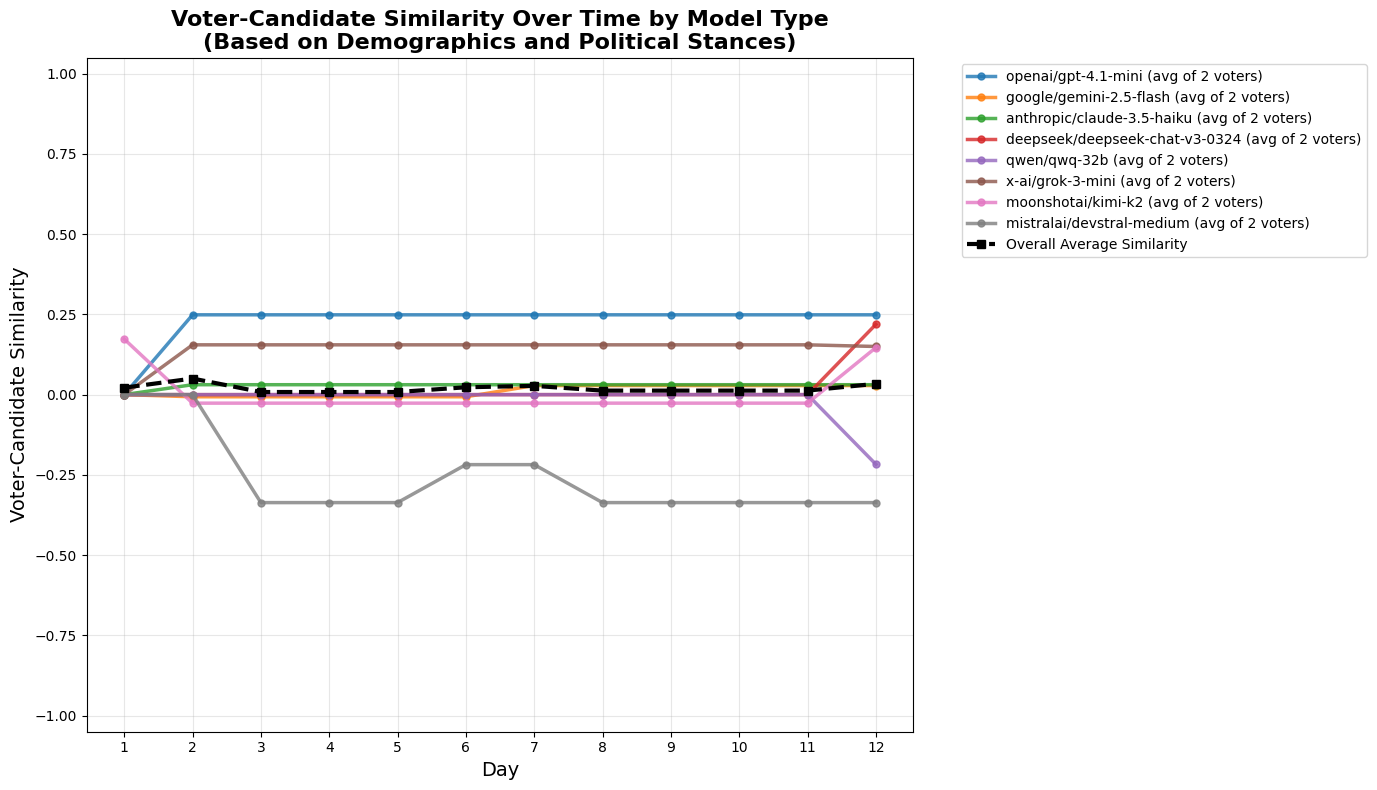

Average similarity by day (overall):
Day 1: 0.022
Day 2: 0.050
Day 3: 0.008
Day 4: 0.008
Day 5: 0.008
Day 6: 0.023
Day 7: 0.027
Day 8: 0.013
Day 9: 0.013
Day 10: 0.013
Day 11: 0.013
Day 12: 0.034

Average similarity by model type:
openai/gpt-4.1-mini: 0.228
google/gemini-2.5-flash: 0.011
anthropic/claude-3.5-haiku: 0.028
deepseek/deepseek-chat-v3-0324: 0.018
qwen/qwq-32b: -0.018
x-ai/grok-3-mini: 0.142
moonshotai/kimi-k2: 0.004
mistralai/devstral-medium: -0.261


In [42]:
# Plot voter-candidate similarity over time by model type
model_similarities, overall_avg_similarities = (
    plot_voter_candidate_similarity_over_time(sim_data)
)

print("Average similarity by day (overall):")
for i, avg_sim in enumerate(overall_avg_similarities):
    print(f"Day {i+1}: {avg_sim:.3f}")

print("\nAverage similarity by model type:")
for model_name, similarities in model_similarities.items():
    avg_for_model = np.mean(similarities)
    print(f"{model_name}: {avg_for_model:.3f}")

In [43]:
def plot_candidate_voter_similarity_with_baseline(data):
    """Plot the average similarity between each candidate and their voters over time with baseline comparisons."""
    history = get_vote_history(data)
    all_agents = get_all_agents(data)
    candidate_agents = get_candidate_agents(data)
    candidate_names = get_candidate_names(
        data, include_abstain=False
    )  # Exclude abstain
    voter_agents = get_voter_agents(data)  # Get only actual voters

    num_days = len(history)
    days = list(range(1, num_days + 1))

    # Store similarity data for each candidate (using agent names as keys)
    candidate_similarities = {name: [] for name in candidate_names}
    overall_similarities = []

    # Store vote counts for each candidate
    candidate_vote_counts = {name: [] for name in candidate_names}

    for day_idx in range(num_days):
        day_votes = history[day_idx]
        day_candidate_sims = {name: [] for name in candidate_names}
        day_vote_counts = {name: 0 for name in candidate_names}

        # Calculate similarities for each voter-candidate pair on this day
        for voter_name, chosen_candidate in day_votes.items():
            # Only include actual voters (exclude candidates from voting)
            if (
                voter_name in voter_agents and chosen_candidate in candidate_names
            ):  # Skip abstain and candidate votes
                # Count votes
                day_vote_counts[chosen_candidate] += 1

                voter_profile = all_agents[voter_name]
                chosen_candidate_profile = candidate_agents[chosen_candidate]

                # Main similarity (voter with their chosen candidate)
                similarity = calculate_similarity(
                    voter_profile, chosen_candidate_profile
                )
                day_candidate_sims[chosen_candidate].append(similarity)

        # Store vote counts for this day
        for name in candidate_names:
            candidate_vote_counts[name].append(day_vote_counts[name])

        # Calculate average similarity for each candidate on this day
        for name in candidate_names:
            if day_candidate_sims[name]:  # If candidate got votes from actual voters
                avg_sim = np.mean(day_candidate_sims[name])
                candidate_similarities[name].append(avg_sim)
            else:  # If candidate got no votes from actual voters
                candidate_similarities[name].append(0)

    # Create the plot with dual y-axes
    fig, ax1 = plt.subplots(figsize=(14, 8))

    # Secondary y-axis for vote counts
    ax2 = ax1.twinx()

    # Plot each candidate's average similarity with their voters over time (main lines)
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd"]
    for i, name in enumerate(candidate_names):
        # Similarity lines on left y-axis
        ax1.plot(
            days,
            candidate_similarities[name],
            marker="o",
            linewidth=3,
            markersize=6,
            label=f"{candidate_agents[name]['model_name']} ({name}) - Similarity",
            color=colors[i % len(colors)],
        )

        # Vote count lines on right y-axis with distinct styling
        ax2.plot(
            days,
            candidate_vote_counts[name],
            marker="^",
            linewidth=1.5,
            markersize=5,
            linestyle="--",
            alpha=0.8,
            color=colors[i % len(colors)],
            markerfacecolor="white",
            markeredgecolor=colors[i % len(colors)],
            markeredgewidth=1.5,
            label=f"{candidate_agents[name]['model_name']} ({name}) - Votes",
        )

    # Configure axes
    ax1.set_xlabel("Day", fontsize=14)
    ax2.set_ylabel("Number of Votes", fontsize=14, color="black")

    ax1.set_title(
        "Average Similarity Between Candidates and Their Voters Over Time\n(With Vote Counts)",
        fontsize=16,
        fontweight="bold",
    )

    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(-1.05, 1.05)  # Updated for cosine similarity range
    ax1.set_xticks(days)

    # Set vote count y-axis limits
    max_votes = max([max(counts) for counts in candidate_vote_counts.values()] + [1])
    ax2.set_ylim(0, max_votes * 1.1)
    ax2.tick_params(axis="y", labelcolor="black")

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
        lines1 + lines2,
        labels1 + labels2,
        fontsize=9,
        bbox_to_anchor=(1.15, 1),
        loc="upper left",
    )

    plt.tight_layout()
    plt.show()

    return (
        candidate_similarities,
        candidate_vote_counts,
    )

Testing the corrected function with agent names:


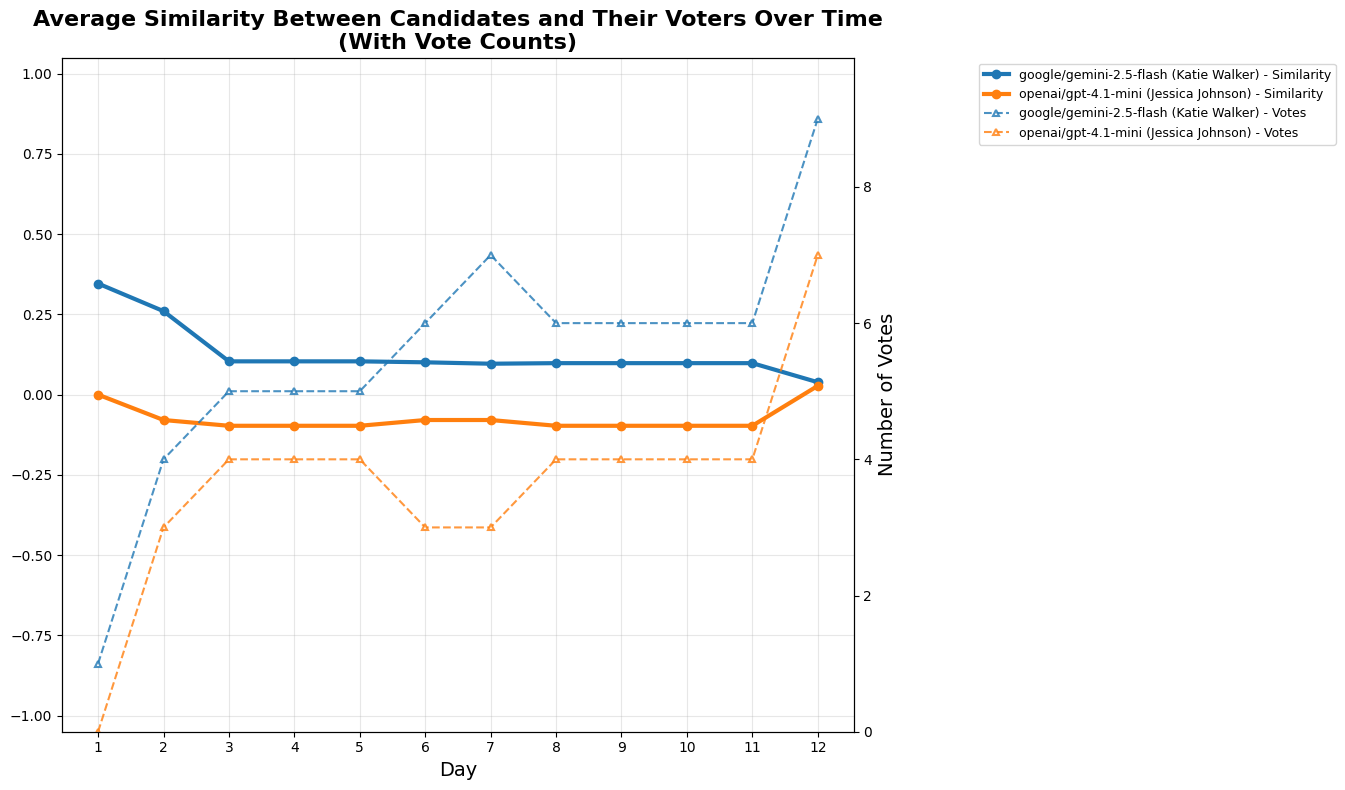


✅ Function executed successfully!
Candidates found: ['Katie Walker', 'Jessica Johnson']
Number of days: 12

Vote count statistics:
Katie Walker: 66 total votes, 5.5 avg per day
Jessica Johnson: 44 total votes, 3.7 avg per day


In [44]:
# Test the corrected function with agent names using data[0]
print("Testing the corrected function with agent names:")
# Test with data[0] to ensure it works with the new function
candidate_sims, vote_counts = plot_candidate_voter_similarity_with_baseline(
    sim_data
)  # Print some statistics
candidate_names = get_candidate_names(sim_data, include_abstain=False)
print(f"\n✅ Function executed successfully!")
print(f"Candidates found: {candidate_names}")
print(f"Number of days: {len(vote_counts[candidate_names[0]])}")

# Print vote count statistics
print(f"\nVote count statistics:")
for candidate in candidate_names:
    total_votes = sum(vote_counts[candidate])
    avg_votes_per_day = np.mean(vote_counts[candidate])
    print(
        f"{candidate}: {total_votes} total votes, {avg_votes_per_day:.1f} avg per day"
    )

Calculating cosine similarity between candidates:
Candidates: ['Katie Walker', 'Jessica Johnson']

Candidate Similarity:
Katie Walker vs Jessica Johnson: -0.8407

Katie Walker background:
  economic_policy: -23
  social_authority: -84
  governmental_power: 66
  foreign_policy: 61
  environmental_approach: -61
  national_identity: -70
  openness: -31
  conscientiousness: 87
  extraversion: -21
  agreeableness: 33
  emotional_stability: 97

Jessica Johnson background:
  economic_policy: -63
  social_authority: 36
  governmental_power: -75
  foreign_policy: -45
  environmental_approach: 61
  national_identity: 65
  openness: 11
  conscientiousness: -64
  extraversion: 9
  agreeableness: 3
  emotional_stability: -77

Political Stance Differences:
  economic_policy: -23 vs -63 (diff: 40)
  social_authority: -84 vs 36 (diff: 120)
  governmental_power: 66 vs -75 (diff: 141)
  foreign_policy: 61 vs -45 (diff: 106)
  environmental_approach: -61 vs 61 (diff: 122)
  national_identity: -70 vs 65 (

,Katie Walker,Jessica Johnson
Mark Campbell,0.275222,-0.450205
Ashley Guzman,0.222052,-0.044291
Chelsea Carter,-0.221737,-0.013378
Roger Campbell,0.069980,-0.049087
Melissa Caldwell,0.368873,-0.170756
Kristina Holt,0.232559,-0.142506
Michael Mccarty,0.029711,-0.280040
Rebecca Estes,-0.068756,0.407714
Kevin Fuller,-0.616316,0.477675
Jimmy Morris,0.046534,0.182424


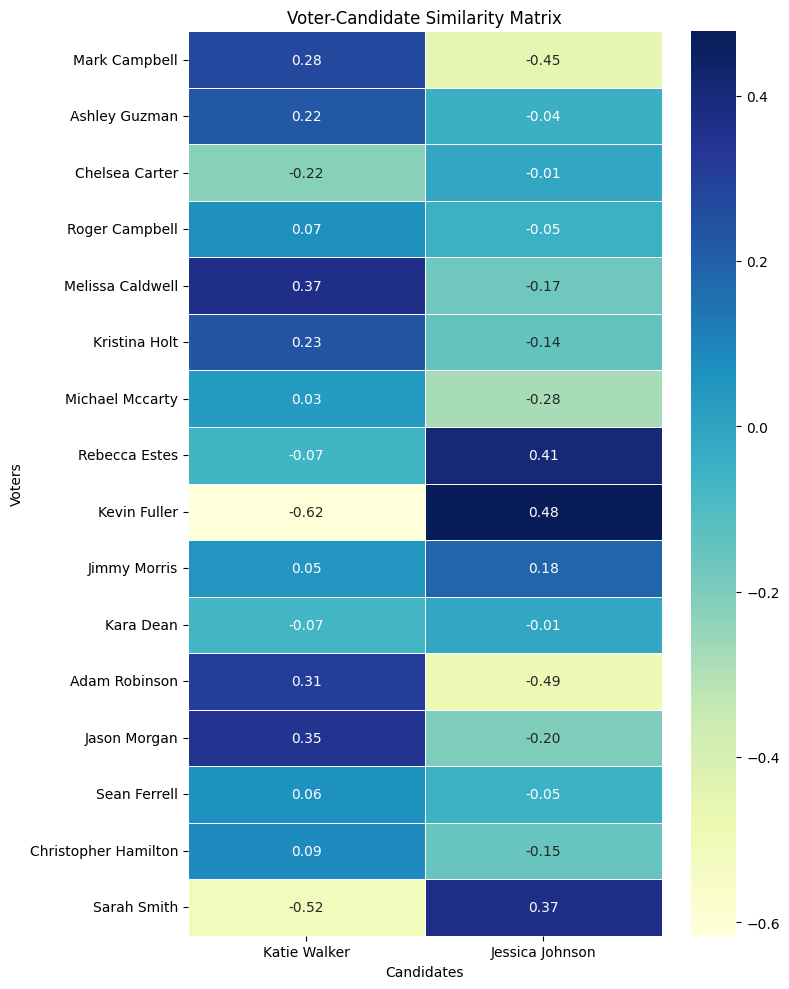

Average similarity for Katie Walker: 0.034
Average similarity for Jessica Johnson: -0.039


In [45]:
# Calculate cosine similarity between the two candidates
candidate_agents = get_candidate_agents(sim_data)
candidate_names = get_candidate_names(sim_data, include_abstain=False)

print("Calculating cosine similarity between candidates:")
print(f"Candidates: {candidate_names}")

# Get the two candidate profiles
candidate1_name = candidate_names[0]
candidate2_name = candidate_names[1]
candidate1_profile = candidate_agents[candidate1_name]
candidate2_profile = candidate_agents[candidate2_name]

# Calculate similarity between the two candidates
candidate_similarity = calculate_similarity(candidate1_profile, candidate2_profile)

print(f"\nCandidate Similarity:")
print(f"{candidate1_name} vs {candidate2_name}: {candidate_similarity:.4f}")

# Show their background differences for context
print(f"\n{candidate1_name} background:")
bg1 = candidate1_profile.get("background", {})
political_attrs = [
    "economic_policy",
    "social_authority",
    "governmental_power",
    "foreign_policy",
    "environmental_approach",
    "national_identity",
    "openness",
    "conscientiousness",
    "extraversion",
    "agreeableness",
    "emotional_stability",
]

for attr in political_attrs:
    if attr in bg1:
        print(f"  {attr}: {bg1[attr]}")

print(f"\n{candidate2_name} background:")
bg2 = candidate2_profile.get("background", {})
for attr in political_attrs:
    if attr in bg2:
        print(f"  {attr}: {bg2[attr]}")

# Calculate differences in key political stances
print(f"\nPolitical Stance Differences:")
for attr in political_attrs:
    val1 = bg1.get(attr, 0)
    val2 = bg2.get(attr, 0)
    diff = abs(val1 - val2)
    print(f"  {attr}: {val1} vs {val2} (diff: {diff})")

print(f"\nOverall cosine similarity: {candidate_similarity:.4f}")
if candidate_similarity > 0.5:
    print("The candidates are quite similar in their political stances.")
elif candidate_similarity > 0:
    print("The candidates have some similarities but also notable differences.")
elif candidate_similarity > -0.5:
    print("The candidates have significant differences in their political stances.")
else:
    print("The candidates have very different political stances.")

# Create a similarity matrix between all voters and all candidates
all_agents = get_all_agents(sim_data)
voter_names = get_voter_names(sim_data)

similarity_matrix = []
for voter_name in voter_names:
    voter_profile = all_agents[voter_name]
    row = []
    for candidate_name in candidate_names:
        candidate_profile = candidate_agents[candidate_name]
        sim = calculate_similarity(voter_profile, candidate_profile)
        row.append(sim)
    similarity_matrix.append(row)

# Convert to DataFrame for better visualization
similarity_df = pd.DataFrame(
    similarity_matrix, index=voter_names, columns=candidate_names
)
display(similarity_df)

# Plot as heatmap
plt.figure(figsize=(8, len(voter_names) * 0.5 + 2))
sns.heatmap(similarity_df, annot=True, cmap="YlGnBu", fmt=".2f", linewidths=0.5)
plt.title("Voter-Candidate Similarity Matrix")
plt.xlabel("Candidates")
plt.ylabel("Voters")
plt.tight_layout()
plt.show()

# Calculate and print the average similarity for each candidate
for candidate in candidate_names:
    avg_value = similarity_df[candidate].mean()
    print(f"Average similarity for {candidate}: {avg_value:.3f}")

In [46]:
# Calculate the optimal average similarity if every voter chose the candidate with the higher similarity

optimal_similarities = [[] for _ in range(len(candidate_names))]
optimal_voters_by_model = [
    {"model_counts": {}, "voters": []} for _ in range(len(candidate_names))
]

voter_agents = get_voter_agents(sim_data)

for voter in voter_names:
    sims = similarity_df.loc[voter].values

    best_candidate_index = np.argmax(sims)
    optimal_similarities[best_candidate_index].append(sims[best_candidate_index])

    # Track which model this voter belongs to
    voter_model = voter_agents[voter].get("model_name", "Unknown")
    optimal_voters_by_model[best_candidate_index]["voters"].append(voter)

    # Count models
    if voter_model not in optimal_voters_by_model[best_candidate_index]["model_counts"]:
        optimal_voters_by_model[best_candidate_index]["model_counts"][voter_model] = 0
    optimal_voters_by_model[best_candidate_index]["model_counts"][voter_model] += 1

print("Optimal voting analysis (if voters chose based on highest similarity):")
print("=" * 70)

for i, candidate in enumerate(candidate_names):
    if optimal_similarities[i]:
        optimal_avg = np.mean(optimal_similarities[i])
        total_voters = len(optimal_similarities[i])
        print(f"\n{candidate}:")
        print(f"  Total optimal votes: {total_voters}")
        print(f"  Optimal average similarity: {optimal_avg:.3f}")
        print(f"  Voting breakdown by model:")

        for model_name, count in optimal_voters_by_model[i]["model_counts"].items():
            percentage = (count / total_voters) * 100
            print(f"    {model_name}: {count} voters ({percentage:.1f}%)")
    else:
        print(f"\n{candidate}: No optimal votes")

# Calculate overall model distribution
print(f"\nOverall model distribution in optimal scenario:")
all_model_counts = {}
total_all_voters = len(voter_names)

for model_data in optimal_voters_by_model:
    for model_name, count in model_data["model_counts"].items():
        if model_name not in all_model_counts:
            all_model_counts[model_name] = 0
        all_model_counts[model_name] += count

for model_name, count in all_model_counts.items():
    percentage = (count / total_all_voters) * 100
    print(f"  {model_name}: {count}/{total_all_voters} voters ({percentage:.1f}%)")

Optimal voting analysis (if voters chose based on highest similarity):

Katie Walker:
  Total optimal votes: 10
  Optimal average similarity: 0.200
  Voting breakdown by model:
    openai/gpt-4.1-mini: 2 voters (20.0%)
    google/gemini-2.5-flash: 1 voters (10.0%)
    anthropic/claude-3.5-haiku: 2 voters (20.0%)
    deepseek/deepseek-chat-v3-0324: 1 voters (10.0%)
    x-ai/grok-3-mini: 1 voters (10.0%)
    moonshotai/kimi-k2: 2 voters (20.0%)
    mistralai/devstral-medium: 1 voters (10.0%)

Jessica Johnson:
  Total optimal votes: 6
  Optimal average similarity: 0.236
  Voting breakdown by model:
    google/gemini-2.5-flash: 1 voters (16.7%)
    deepseek/deepseek-chat-v3-0324: 1 voters (16.7%)
    qwen/qwq-32b: 2 voters (33.3%)
    x-ai/grok-3-mini: 1 voters (16.7%)
    mistralai/devstral-medium: 1 voters (16.7%)

Overall model distribution in optimal scenario:
  openai/gpt-4.1-mini: 2/16 voters (12.5%)
  google/gemini-2.5-flash: 2/16 voters (12.5%)
  anthropic/claude-3.5-haiku: 2/16 vo

In [47]:
def plot_candidate_similarity_boxplots(data):
    """Create side-by-side box plots showing the distribution of voter similarity scores for each candidate over time."""
    history = get_vote_history(data)
    all_agents = get_all_agents(data)
    candidate_agents = get_candidate_agents(data)
    candidate_names = get_candidate_names(data, include_abstain=False)
    voter_agents = get_voter_agents(data)  # Get only actual voters

    num_days = len(history)

    # Prepare data for box plots
    plot_data = []

    for day_idx in range(num_days):
        day = day_idx + 1
        day_votes = history[day_idx]

        # For each candidate, collect all similarity scores for voters who voted for them
        for candidate_name in candidate_names:
            voter_similarities = []

            for voter_name, chosen_candidate in day_votes.items():
                # Only include actual voters (exclude candidates from voting)
                if voter_name in voter_agents and chosen_candidate == candidate_name:
                    voter_profile = all_agents[voter_name]
                    candidate_profile = candidate_agents[candidate_name]
                    similarity = calculate_similarity(voter_profile, candidate_profile)
                    voter_similarities.append(similarity)

            # Add each similarity score as a separate row
            for similarity in voter_similarities:
                plot_data.append(
                    {
                        "Day": day,
                        "Candidate": f"{candidate_agents[candidate_name]['model_name']} ({candidate_name})",
                        "SimilarityScore": similarity,
                    }
                )

    # Convert to DataFrame
    df = pd.DataFrame(plot_data)

    # Create the box plot
    plt.figure(figsize=(16, 8))

    # Create side-by-side box plots
    ax = sns.boxplot(
        data=df,
        x="Day",
        y="SimilarityScore",
        hue="Candidate",
        palette=["#1f77b4", "#ff7f0e"],  # Blue and orange for the two candidates
        showfliers=True,  # Show outliers
        width=0.6,
    )

    # Customize the plot
    plt.title(
        "Distribution of Voter-Candidate Similarity Scores Over Time\n(Box Plots Showing Full Distributions)",
        fontsize=16,
        fontweight="bold",
    )
    plt.xlabel("Day", fontsize=14)
    plt.ylabel("Voter-Candidate Similarity Score", fontsize=14)
    plt.ylim(-1.05, 1.05)  # Cosine similarity range

    # Improve legend
    plt.legend(
        title="Candidate", bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10
    )

    # Add grid for better readability
    plt.grid(True, alpha=0.3, axis="y")

    # Rotate x-axis labels if there are many days
    if num_days > 10:
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("Summary Statistics by Day and Candidate:")
    print("=" * 50)

    for day in sorted(df["Day"].unique()):
        print(f"\nDay {day}:")
        day_data = df[df["Day"] == day]

        for candidate in candidate_names:
            candidate_label = (
                f"{candidate_agents[candidate]['model_name']} ({candidate})"
            )
            candidate_data = day_data[day_data["Candidate"] == candidate_label][
                "SimilarityScore"
            ]

            # Find voters who voted for this candidate on this day
            voters_for_candidate = [
                voter_name
                for voter_name, chosen_candidate in history[day - 1].items()
                if voter_name in voter_agents and chosen_candidate == candidate
            ]

            if len(candidate_data) > 0:
                print(f"  {candidate_label}:")
                print(f"    Count: {len(candidate_data)}")
                print(f"    Mean: {candidate_data.mean():.3f}")
                print(f"    Median: {candidate_data.median():.3f}")
                print(f"    Std Dev: {candidate_data.std():.3f}")
                print(f"    Min: {candidate_data.min():.3f}")
                print(f"    Max: {candidate_data.max():.3f}")
                if voters_for_candidate:
                    print(f"    Voters (by model):")
                    for voter in voters_for_candidate:
                        model = (
                            all_agents[voter]["model_name"]
                            if voter in all_agents
                            else "Unknown"
                        )
                        print(f"      - {model}")
                else:
                    print(f"    Voters: None")
            else:
                print(f"  {candidate_label}: No votes")

Creating box plots for voter-candidate similarity distributions...


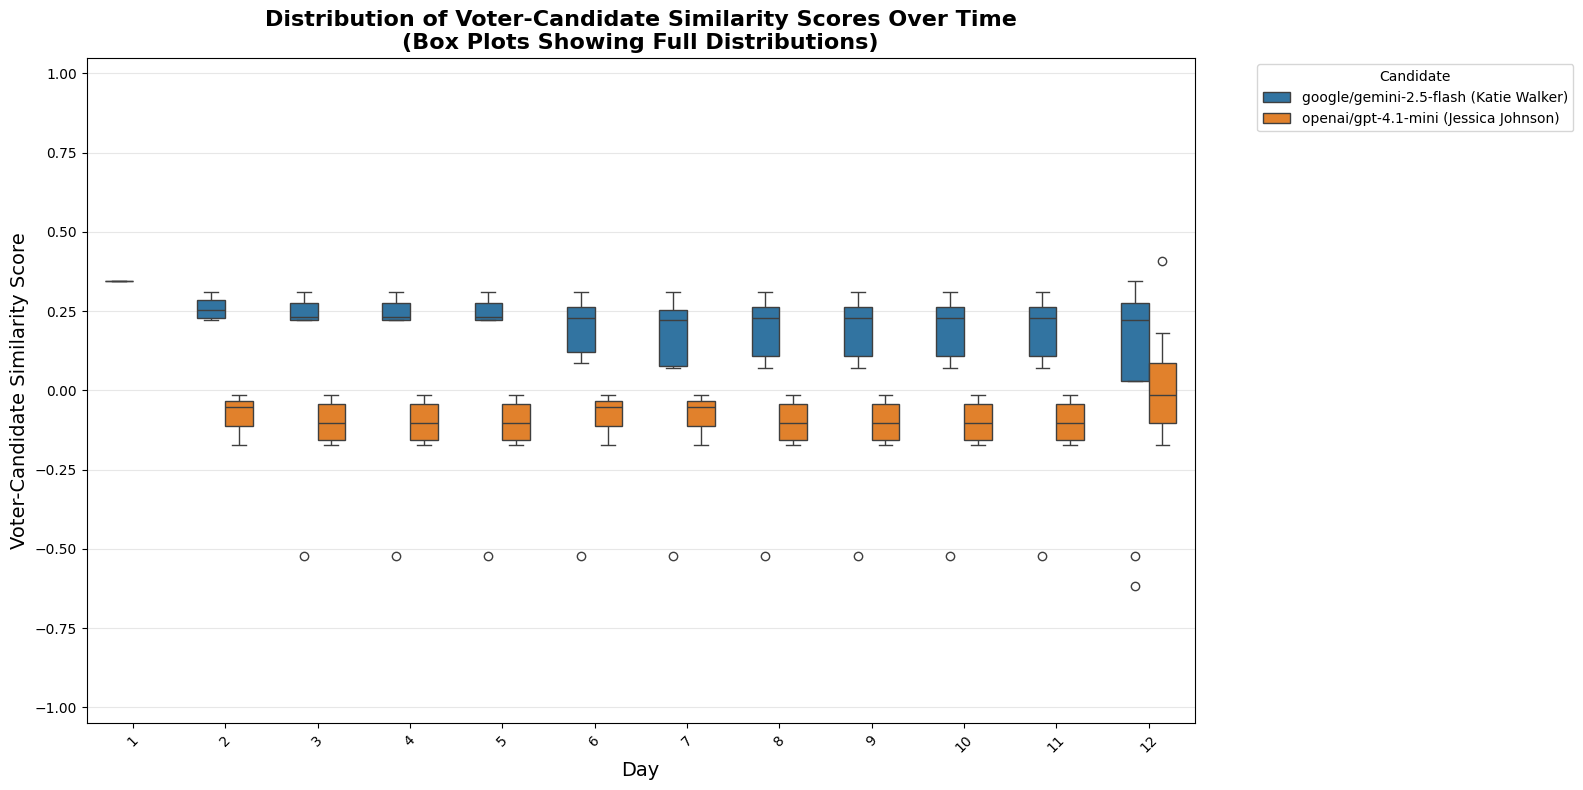

Summary Statistics by Day and Candidate:

Day 1:
  google/gemini-2.5-flash (Katie Walker):
    Count: 1
    Mean: 0.346
    Median: 0.346
    Std Dev: nan
    Min: 0.346
    Max: 0.346
    Voters (by model):
      - moonshotai/kimi-k2
  openai/gpt-4.1-mini (Jessica Johnson): No votes

Day 2:
  google/gemini-2.5-flash (Katie Walker):
    Count: 4
    Mean: 0.260
    Median: 0.254
    Std Dev: 0.041
    Min: 0.222
    Max: 0.310
    Voters (by model):
      - openai/gpt-4.1-mini
      - openai/gpt-4.1-mini
      - anthropic/claude-3.5-haiku
      - x-ai/grok-3-mini
  openai/gpt-4.1-mini (Jessica Johnson):
    Count: 3
    Mean: -0.079
    Median: -0.053
    Std Dev: 0.082
    Min: -0.171
    Max: -0.013
    Voters (by model):
      - google/gemini-2.5-flash
      - anthropic/claude-3.5-haiku
      - moonshotai/kimi-k2

Day 3:
  google/gemini-2.5-flash (Katie Walker):
    Count: 5
    Mean: 0.104
    Median: 0.233
    Std Dev: 0.351
    Min: -0.522
    Max: 0.310
    Voters (by model):
  

In [48]:
# Create side-by-side box plots showing similarity score distributions
print("Creating box plots for voter-candidate similarity distributions...")
plot_candidate_similarity_boxplots(sim_data)